In [4]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

init_notebook_mode(connected=True)
seed = 123
random.seed = seed

In [14]:
print(pd.__version__)

2.1.1


In [6]:
_dfs_list = []
for csv_filename in tqdm(glob.glob('/Users/dmitrykorzhov/Desktop/Root/projects/bci_stuff/alcoholic_data_eeg/SMNI_CMI_TRAIN/*.csv')):
    _dfs_list.append(pd.read_csv(csv_filename))
df = pd.concat(_dfs_list)
del(_dfs_list)
EEG_data = df.drop(['Unnamed: 0'], axis=1)

100%|██████████| 468/468 [00:03<00:00, 137.93it/s]


In [8]:
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' 

In [9]:
EEG_data.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,19,FP1,0,6.887,c,S2 nomatch,0,co2c0000340,0.000000
1,19,FP1,1,2.004,c,S2 nomatch,0,co2c0000340,0.003906
2,19,FP1,2,-1.414,c,S2 nomatch,0,co2c0000340,0.007812
3,19,FP1,3,-2.391,c,S2 nomatch,0,co2c0000340,0.011719
4,19,FP1,4,0.051,c,S2 nomatch,0,co2c0000340,0.015625


In [15]:
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data = EEG_data[(EEG_data['sensor position'] != 'X') & (EEG_data['sensor position'] != 'Y') & (EEG_data['sensor position'] != 'nd')]

In [20]:
def sample_data(stimulus, random_id=random.randint(0,7)):
    alcoholic_id = EEG_data['name'][(EEG_data['subject identifier'] == 'a') & 
                                    (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    control_id = EEG_data['name'][(EEG_data['subject identifier'] == 'c') & 
                                  (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    
    alcoholic_trial_number = EEG_data['trial number'][(EEG_data['name'] == alcoholic_id) & (EEG_data['matching condition'] == stimulus)].min()
    control_trial_number = EEG_data['trial number'][(EEG_data['name'] == control_id) & (EEG_data['matching condition'] == stimulus)].min()

    alcoholic_df = EEG_data[(EEG_data['name'] == alcoholic_id) & (EEG_data['trial number'] == alcoholic_trial_number)]
    control_df = EEG_data[(EEG_data['name'] == control_id) & (EEG_data['trial number'] == control_trial_number)]
    
    return pd.concat([alcoholic_df, control_df], ignore_index=True)

In [21]:
stimulus = 'S1 obj'
S1_sample_df = sample_data(stimulus=stimulus, random_id=1)

stimulus = 'S2 match'
S2_m_sample_df = sample_data(stimulus=stimulus, random_id=1)

stimulus = 'S2 nomatch'
S2_nm_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [22]:
sample_corr_df = pd.pivot_table(S2_nm_sample_df[S2_nm_sample_df['subject identifier'] == 'a'], values='sensor value', index='sample num', columns='sensor position').corr()

list_of_pairs = []
j = 0
for column in sample_corr_df.columns:
    j += 1
    for i in range(j, len(sample_corr_df)):
        if column != sample_corr_df.index[i]:
            temp_pair = [column + '-' + sample_corr_df.index[i]]
            list_of_pairs.append(temp_pair)

In [23]:
def get_correlated_pairs_sample(threshold, correlation_df, group):
    corr_pairs_dict = {}
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    j = 0
    for column in correlation_df.columns:
        j += 1
        for i in range(j, len(correlation_df)):
            if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    print('Channel pairs that have correlation value >= ' + str(threshold) + ' (' + group + ' group):')
    print(corr_count['channel_pair'][corr_count['count'] > 0].tolist())


In [26]:
def plot_sensors_correlation(df, threshold_value):
    """Funtion plots the the correlation plots between sensor positions for each group"""
    correlations_alcoholic = pd.pivot_table(df[df['subject identifier'] == 'a'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    correlations_control = pd.pivot_table(df[df['subject identifier'] == 'c'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    fig = plt.figure(figsize=(17,10))
    ax = fig.add_subplot(121)
    ax.set_title('Alcoholic group', fontsize=14)
    mask = np.zeros_like(correlations_alcoholic, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(correlations_alcoholic, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax = fig.add_subplot(122)
    ax.set_title('Control group', fontsize=14)
    mask = np.zeros_like(correlations_control, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_control, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.suptitle('Correlation between Sensor Positions for ' + df['matching condition'].unique()[0] + ' stimulus', fontsize=16)
    plt.show()
    
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_alcoholic, group='Alcoholic')
    print('\n')
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_control, group='Control')

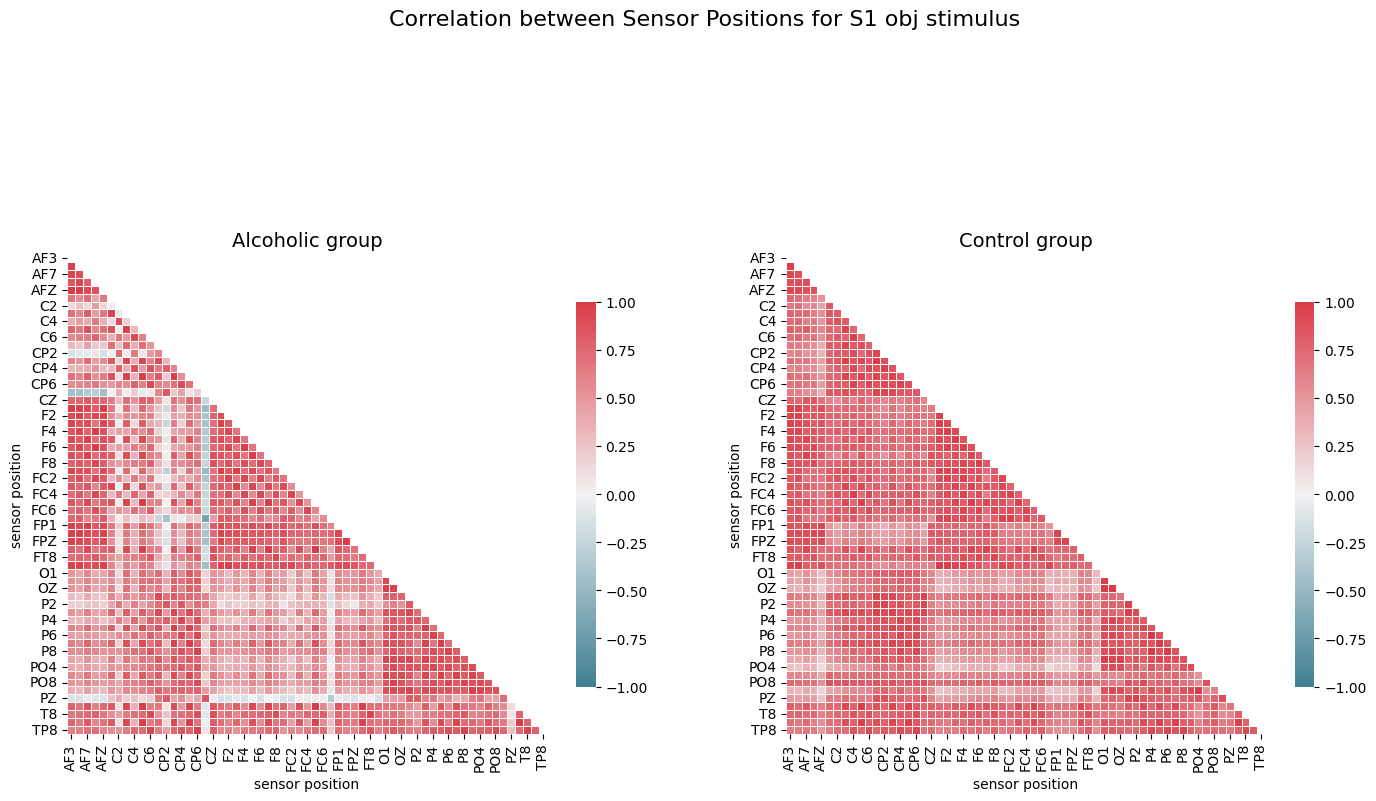

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AF3-F1', 'AF4-AFZ', 'AF7-FP1', 'AF8-F4', 'AF8-F6', 'AFZ-F1', 'C5-CP5', 'C5-FC5', 'C5-FT7', 'C5-T7', 'C5-TP7', 'CP3-CP5', 'CP3-P5', 'CP5-TP7', 'F1-FC1', 'F3-FC1', 'F4-F6', 'F5-F7', 'F5-FC5', 'F7-FC5', 'F7-FT7', 'FC5-FT7', 'FC5-T7', 'FP2-FPZ', 'FT7-T7', 'O1-OZ', 'P3-P5', 'P5-P7', 'PO3-POZ', 'T7-TP7']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AF4', 'C5-T7', 'CP1-CP3', 'CP5-TP7', 'F1-F3', 'F1-FZ', 'F2-F4', 'F2-FZ', 'F3-F5', 'F6-F8', 'FC2-FCZ', 'O1-O2', 'O1-OZ', 'O2-OZ', 'P1-P3', 'P2-PZ', 'P4-P6', 'P4-P8', 'P5-P7', 'P6-P8', 'PO4-POZ', 'T7-TP7']


/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_28358/4023883405.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_28358/4023883405.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [27]:
plot_sensors_correlation(df=S1_sample_df, threshold_value=.97)

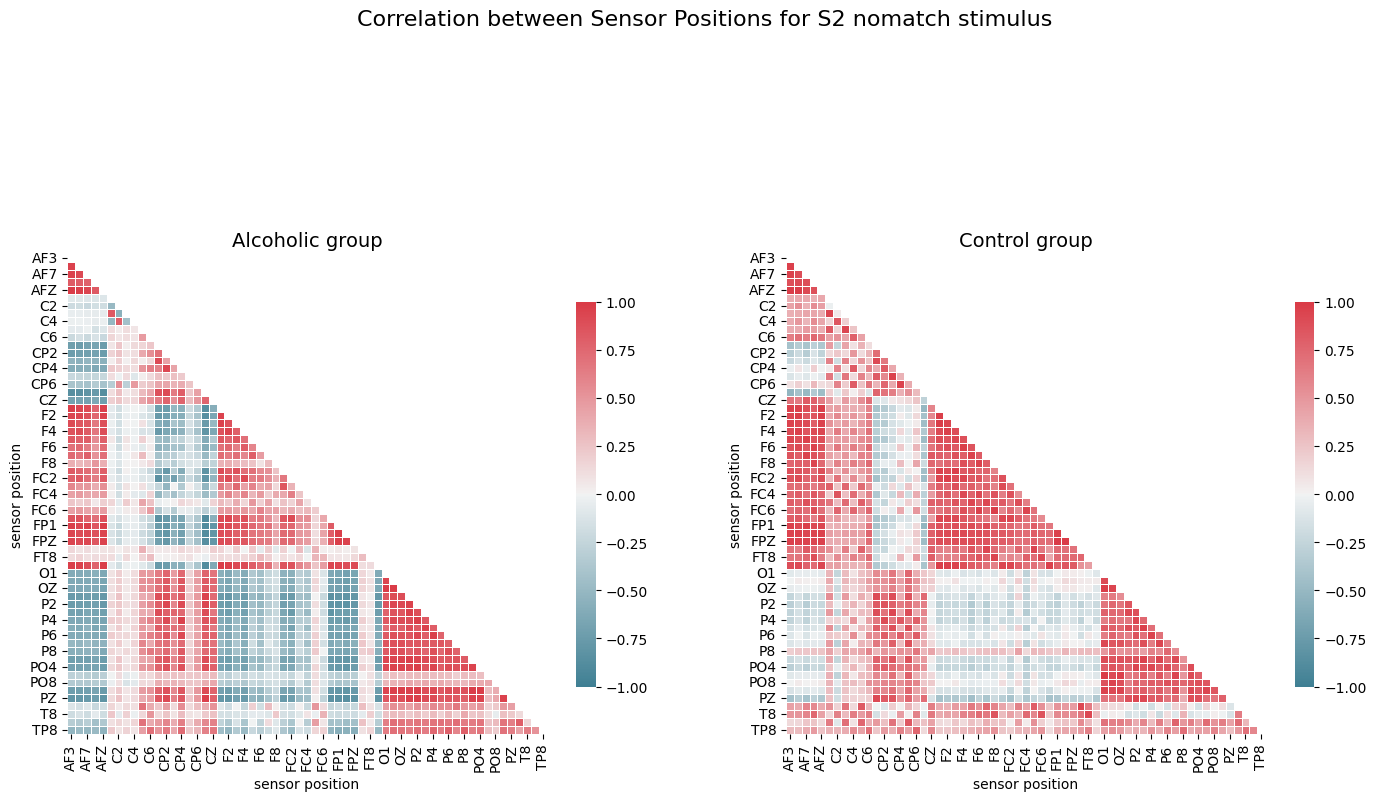

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AF3-F1', 'AF3-FP1', 'AF3-FZ', 'AF4-AFZ', 'AFZ-FP1', 'AFZ-FZ', 'F1-FZ', 'F2-FZ', 'FP1-FP2', 'FP1-FPZ', 'O1-OZ', 'O2-OZ', 'OZ-POZ', 'P2-P4', 'P2-PO4', 'P2-POZ', 'P2-PZ', 'P4-P6', 'PO3-POZ', 'PO4-POZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AFZ', 'AF4-AFZ', 'AF4-F2', 'AF7-FP1', 'F1-F2', 'F1-F3', 'F1-FZ', 'F4-F6', 'F8-FC6', 'FP1-FPZ', 'FP2-FPZ', 'O1-OZ', 'O1-PO7']


/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_28358/4023883405.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_28358/4023883405.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [29]:
plot_sensors_correlation(df=S2_nm_sample_df, threshold_value=.97)

In [30]:
stimulus_list = EEG_data['matching condition'].unique().tolist() 
channels_list = EEG_data['channel'].unique().tolist() 

agg_df = EEG_data.groupby(['subject identifier', 'matching condition', 'sensor position'], as_index=False)[['sensor value']].mean()

In [32]:
def get_p_value(stimulus, sensor):
    x = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'a') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    y = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'c') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    stat, p = mannwhitneyu(x=x, 
                           y=y,
                           alternative='two-sided')
    return p

In [34]:
stat_test_results = pd.DataFrame({'stimulus': [], 
                                  'sensor': [],
                                  'p_value': []})

temp_results = []  # Создаем временный список для хранения результатов

for sensor in tqdm(EEG_data['sensor position'].unique()):
    for stimulus in EEG_data['matching condition'].unique():
        p_value = get_p_value(stimulus=stimulus, sensor=sensor)  # Получаем p-value
        temp_results.append({'stimulus': stimulus, 'sensor': sensor, 'p_value': p_value})

# Преобразуем список словарей в DataFrame и добавляем его к stat_test_results
stat_test_results = pd.concat([stat_test_results, pd.DataFrame(temp_results)], ignore_index=True)

stat_test_results['reject_null'] = stat_test_results['p_value'] <= 0.05

100%|██████████| 61/61 [03:16<00:00,  3.23s/it]


In [35]:
stat_test_results.groupby(['stimulus'])[['reject_null']].mean()

,reject_null
stimulus,
S1 obj,0.901639
S2 match,0.770492
S2 nomatch,0.803279


In [36]:
data = []
for stimulus in stimulus_list:
    trace = go.Bar(x=stat_test_results['sensor'][stat_test_results['stimulus'] == stimulus],
                    y=stat_test_results['reject_null'][stat_test_results['stimulus'] == stimulus],
                    name=stimulus)
    data.append(trace)

layout = go.Layout(title='Amount of Significant Differences for each Channel',
                   xaxis=dict(title='Sensor Position'),
                   yaxis=dict(title='Is Significant',
                              showticklabels=False),
                   barmode='stack')
fig = go.Figure(data=data, layout=layout)
iplot(fig)